In [22]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from typing import Tuple

# Load and preprocess data

In [2]:
data = pd.read_csv(rf'C:\Users\MY PC\Project\data\AAPL_stock.csv')
data["Date"] = pd.to_datetime(data["Date"])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021709,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000


In [3]:
min_time = data["Date"].min().strftime('%Y-%m-%d') # type: ignore
max_time = data["Date"].max().strftime('%Y-%m-%d') # type: ignore
print(min_time)
print(max_time)

2015-01-02
2024-06-28


### Split data into train test sets and create time lags

In [4]:
def create_lags(df, target_col, lags = 1):
	df_lag = df.copy()
	for lag in range(1, lags + 1):
		df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)

	df_lag.dropna(inplace=True)
	return df_lag

df_lagged = create_lags(data, "Close", lags=5)
X = df_lagged.drop(["Close"], axis=1)
y = df_lagged["Close"]

In [5]:
Y = pd.concat([X["Date"], y], axis=1)
Y

,Date,Close
5,2015-01-09,28.002501
6,2015-01-12,27.312500
7,2015-01-13,27.555000
8,2015-01-14,27.450001
9,2015-01-15,26.705000
...,...,...
2383,2024-06-24,208.139999
2384,2024-06-25,209.070007
2385,2024-06-26,213.250000
2386,2024-06-27,214.100006


In [6]:
X

,Date,Open,High,Low,Adj Close,Volume,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
5,2015-01-09,28.167500,28.312500,27.552500,24.971437,214798000,27.972500,26.937500,26.565001,26.562500,27.332500
6,2015-01-12,28.150000,28.157499,27.200001,24.356125,198603200,28.002501,27.972500,26.937500,26.565001,26.562500
7,2015-01-13,27.857500,28.200001,27.227501,24.572378,268367600,27.312500,28.002501,27.972500,26.937500,26.565001
8,2015-01-14,27.260000,27.622499,27.125000,24.478737,195826400,27.555000,27.312500,28.002501,27.972500,26.937500
9,2015-01-15,27.500000,27.514999,26.665001,23.814383,240056000,27.450001,27.555000,27.312500,28.002501,27.972500
...,...,...,...,...,...,...,...,...,...,...,...
2383,2024-06-24,207.720001,212.699997,206.589996,207.899353,80727000,207.490005,209.679993,214.289993,216.669998,212.490005
2384,2024-06-25,209.149994,211.380005,208.610001,208.828293,56713900,208.139999,207.490005,209.679993,214.289993,216.669998
2385,2024-06-26,211.500000,214.860001,210.639999,213.003448,66213200,209.070007,208.139999,207.490005,209.679993,214.289993
2386,2024-06-27,214.690002,215.740005,212.350006,213.852478,49772700,213.250000,209.070007,208.139999,207.490005,209.679993


In [7]:
def split_data(data, split_time):
	train_data = data[data["Date"] < split_time].set_index("Date").copy()
	test_data = data[data["Date"] >= split_time].set_index("Date").copy()
	return train_data, test_data

In [12]:
X_train, X_test = split_data(X, "2024-03-01")
y_train, y_test = split_data(Y, "2024-03-01")
print(f"Length of X train data: {len(X_train)}")
print(f"Length of X test data: {len(X_test)}")
print(f"Length of y train data: {len(y_train)}")
print(f"Length of y test data: {len(y_test)}")

Length of X train data: 2300
Length of X test data: 83
Length of y train data: 2300
Length of y test data: 83


In [13]:
X_train.head()

,Open,High,Low,Adj Close,Volume,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
Date,,,,,,,,,,
2015-01-09,28.1675,28.312500,27.552500,24.971437,214798000,27.972500,26.937500,26.565001,26.562500,27.332500
2015-01-12,28.1500,28.157499,27.200001,24.356125,198603200,28.002501,27.972500,26.937500,26.565001,26.562500
2015-01-13,27.8575,28.200001,27.227501,24.572378,268367600,27.312500,28.002501,27.972500,26.937500,26.565001
2015-01-14,27.2600,27.622499,27.125000,24.478737,195826400,27.555000,27.312500,28.002501,27.972500,26.937500
2015-01-15,27.5000,27.514999,26.665001,23.814383,240056000,27.450001,27.555000,27.312500,28.002501,27.972500


# XGBoost time series forecasting
- Treats time series forecasting like a regression problem
- Evaluates model with walk-forward validation instead of k-fold

In [14]:
def hypeparam_tune_xgboost(X_train, y_train, X_test, y_test) -> XGBRegressor:
    """
    Find the best set of hyperparameters for the XGBoost model
    
    Parameters:
    X_train (pd.DataFrame): The training data
    y_train (pd.DataFrame): The training labels
    X_test (pd.DataFrame): The testing data
    y_test (pd.DataFrame): The testing labels
    
    Returns:
    best_model (XGBRegressor): The best XGBoost model
    """
    # Set up the parameter grid for tuning the hyperparameters
    param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
	}
    model = XGBRegressor()
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
								   scoring='neg_mean_squared_error', n_iter=10, cv=3, verbose=1)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    best_model = random_search.best_estimator_
    y_pred_best = best_model.predict(X_test) # type: ignore
    best_mse = mse(y_test, y_pred_best)
    print(f"Best MSE: {best_mse}")
    
    return best_model

In [15]:
tuned_model = hypeparam_tune_xgboost(X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best MSE: 46.15679671176073


Lag: 1, MSE: 45.863836412110494
Lag: 2, MSE: 45.63842099993941
Lag: 3, MSE: 45.29863539456493
Lag: 4, MSE: 45.900033739246794
Lag: 5, MSE: 46.15679671176073
Lag: 6, MSE: 46.211926833549775
Lag: 7, MSE: 45.95382465221305
Lag: 8, MSE: 45.50000661635404
Lag: 9, MSE: 45.69284545545222
Lag: 10, MSE: 45.501964990711656

Best Lag: 3, Best MSE: 45.29863539456493


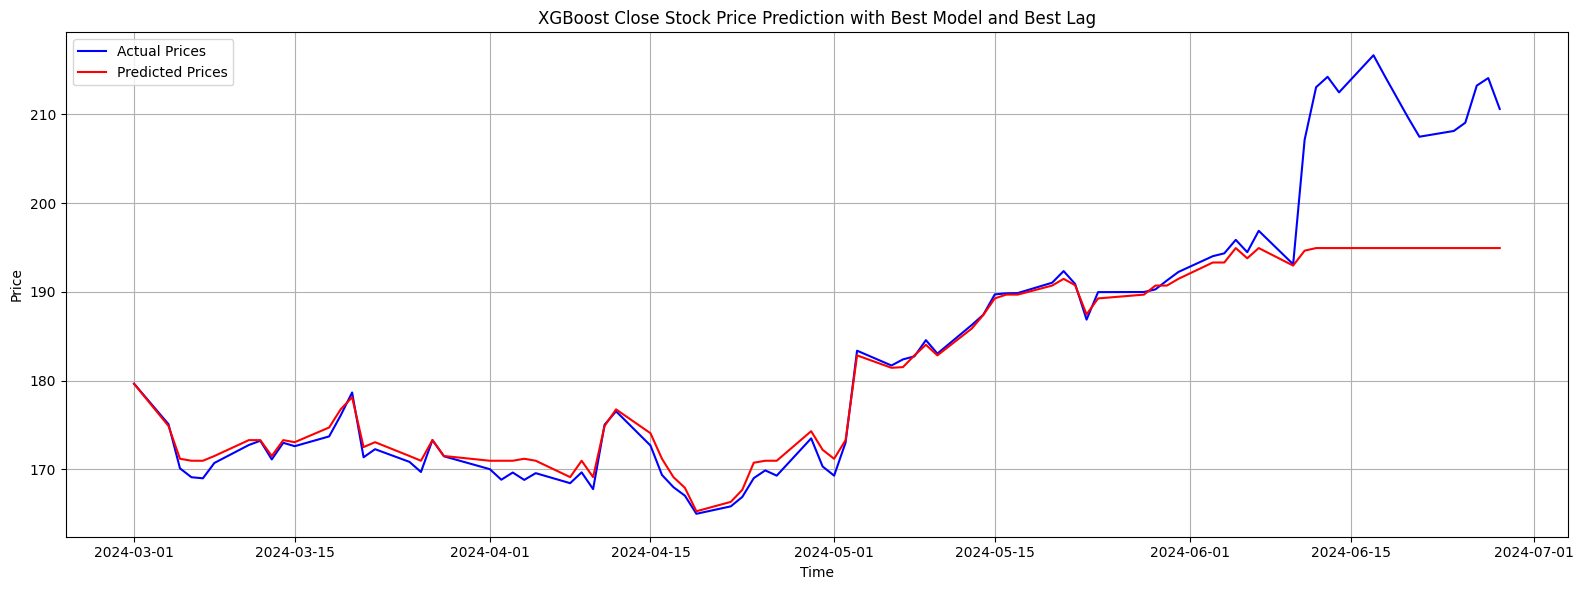

In [23]:
def find_best_lag(df, target_col, model, max_lag=10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find the best lag value by testing different lags and selecting the one with the lowest MSE.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the time series data.
    target_col (str): The target variable for prediction.
    max_lag (int): The maximum number of lags to test.
    
    Returns:
    best_lag (int): The lag value that results in the lowest MSE.
    mse_scores (dict): A dictionary containing MSE scores for each lag value.
    """
    mse_scores = {}

    # Loop over different lag values
    for lag in range(1, max_lag + 1):
        df_lagged = create_lags(df, target_col, lags=lag)
        
        X = df_lagged.drop([target_col], axis=1)
        Y =  pd.concat([X["Date"], df_lagged[target_col]], axis=1)
        X_train, X_test = split_data(X, "2024-03-01")
        y_train, y_test = split_data(Y, "2024-03-01")
           
        # Define and train the XGBoost model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate MSE for the current lag value
        mserror = mse(y_test, y_pred)
        mse_scores[lag] = mserror
        print(f"Lag: {lag}, MSE: {mserror}")
    
    # Find the lag with the lowest MSE
    best_lag = min(mse_scores, key=mse_scores.get) # type: ignore
    print(f"\nBest Lag: {best_lag}, Best MSE: {mse_scores[best_lag]}")
    
    return y_pred, y_test # type: ignore

predicted, actual = find_best_lag(data, "Close", tuned_model, max_lag=10)

# Plot the actual and predicted values for the best lag
plt.figure(figsize=(16, 6))
plt.plot(df_lagged["Date"].iloc[-len(y_test):], actual, color='blue', label='Actual Prices')
plt.plot(df_lagged["Date"].iloc[-len(y_test):], predicted, color='red', label='Predicted Prices')
plt.title(f'XGBoost Close Stock Price Prediction with Best Model and Best Lag')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()